<a href="https://colab.research.google.com/github/esharma3/Time-Series-Analysis/blob/master/08_Multivariate_Time_Series_Modeling_using_Facebook_Prophet_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Time Series Modeling using Facebook Prophet - MULTIVARIATE Modelling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.grid"] = False


In [ ]:
# hourly data, only a asubset has been taken here

df = pd.read_csv(
    "https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv"
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeStamp  49205 non-null  object 
 1   demand     49124 non-null  float64
 2   precip     48975 non-null  float64
 3   temp       49019 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
df["timeStamp"] = pd.to_datetime(df["timeStamp"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [ ]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [ ]:
ny_df = df.set_index("timeStamp")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fee037247b8>,
      dtype=object)

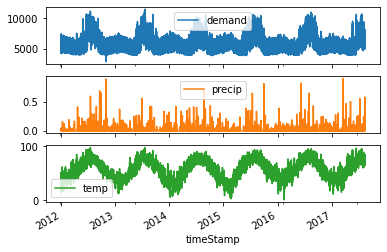

In [ ]:
ny_df.plot(subplots=True)

In [ ]:
# resampling the data from hourly to daily level

ny_df_daily = ny_df.resample("D").mean()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fee032d0320>,
      dtype=object)

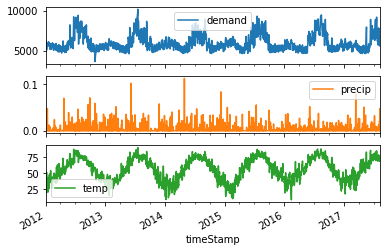

In [ ]:
# plotting the resampled data

ny_df_daily.plot(subplots=True)

In [ ]:
from fbprophet import Prophet

FB Prophet needs cols to have certain names - first is the timeStamp column that FB requires to be named as "ds" and second is the target column that FB requires to be named as "y". Extra "temp" column is for multivariate analysis.

In [ ]:
ny_df_final = ny_df_daily.reset_index()[["timeStamp", "demand", "temp"]].rename({"timeStamp":"ds", "demand":"y", "temp":"temp"}, axis="columns")

In [ ]:
ny_df_final

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500
...,...,...,...
2046,2017-08-08,6471.626042,71.039167
2047,2017-08-09,6811.112167,73.852500
2048,2017-08-10,5582.297000,75.217500
2049,2017-08-11,NaN,72.767917


### Above, we can see that y has some NaN values. FB takes care of missing values in y variable but if we want we can handle those explicitly too (if we have certain data requirements) but FB DOES NOT handle is missing values in extra columns like "temp". So we need to explicitly check for missing values in this col and impute those.

In [ ]:
ny_df_final.query("temp != temp")

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [ ]:
ny_df_final["temp"] = ny_df_final["temp"].fillna(method="ffill")

In [ ]:
ny_df_final.query("temp != temp")   # no more missing data present

,ds,y,temp


In the 07 notebook, we saw that the black data points were outside of our confidence interval. Even though our model was good but it could not predict well for those points. So this time we are trying using an additional feature "temp" to see if we get better results.

In [ ]:
# adding a col for month

ny_df_final["month"] = ny_df_final["ds"].dt.month

In [ ]:
ny_df_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


In [ ]:
# visualizing the data to see what are the characteristics of the outliers

fig = px.line(ny_df_final, x="ds", y="y", hover_data=["temp", "month"], title="NYC Energy Demand")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=2, label="3y", step="year", stepmode="backward"),
                      dict(count=3, label="5y", step="year", stepmode="backward"),
                      dict(step="all")

        ])
    )
)

fig.show()

### Above - 

If we hover over the outliers (spikes) we will notice that these are in summer months of Jul-Aug (7 or 8) and temp is 86 or more. By using the temp feature, we are able to see that our univariate model was not able to predict correctly for summer months that had high temperature.

We will now feed the model additional intelligence so that it can model these points too.

In [ ]:
# doing further analysis
# finding each month's max, min and mean temp
# below we can see that summer months - 6,7 and 8 have higher min, max and mean temps

ny_df_final[["month", "temp"]].groupby("month").agg({"temp": {"max", "min", "mean"}})

temp                      
             min        max       mean
month                                 
1       9.507917  55.420455  33.432140
2       9.015000  59.360000  34.517758
3      20.291667  67.878333  41.419884
4      33.045833  72.992083  52.600204
5      48.090833  82.576250  62.543994
6      52.405833  86.916667  71.334418
7      66.417083  89.606667  77.595627
8      68.042083  87.426250  75.525947
9      57.274583  84.448750  69.550306
10     42.106250  74.277500  58.642895
11     27.172500  67.606250  47.225638
12     22.429583  64.735000  41.520068

In [ ]:
# checking if there is any strong correlation between y and temp
# below there seems to be good correlation but not a very strong one

ny_df_final[["y", "temp"]].corr()

,y,temp
y,1.000000,0.560888
temp,0.560888,1.000000


In [ ]:
ny_df_final.query("temp > 80")[["y", "temp"]].corr()

,y,temp
y,1.000000,0.552918
temp,0.552918,1.000000


In [ ]:
ny_df_final.query("temp <= 80")[["y", "temp"]].corr()

,y,temp
y,1.000000,0.470562
temp,0.470562,1.000000


In [ ]:
def summer_temp(temp):
  if temp > 80:
    return 1
  else:
    return 0

In [ ]:
# adding a new col to track if it is a summer temp

ny_df_final["summer_temp"] = ny_df_final["temp"].apply(summer_temp)

In [ ]:
ny_df_final.head()

,ds,y,temp,month,summer_temp
0,2012-01-01,4954.833333,46.510000,1,0
1,2012-01-02,5302.954167,40.496667,1,0
2,2012-01-03,6095.512500,26.672500,1,0
3,2012-01-04,6336.266667,20.585000,1,0
4,2012-01-05,6130.245833,33.577500,1,0


In [ ]:
# dividing months into 3 bins

ny_df_final["month_bins"] = pd.cut(ny_df_final["month"], bins=3, labels=False)

In [ ]:
ny_df_final.head()

,ds,y,temp,month,summer_temp,month_bins
0,2012-01-01,4954.833333,46.510000,1,0,0
1,2012-01-02,5302.954167,40.496667,1,0,0
2,2012-01-03,6095.512500,26.672500,1,0,0
3,2012-01-04,6336.266667,20.585000,1,0,0
4,2012-01-05,6130.245833,33.577500,1,0,0


In [ ]:
# splitting up data into train and test

train = ny_df_final[(ny_df_final["ds"] >= "12-01-01") & (ny_df_final["ds"] <= "2017-04-30")]

test = ny_df_final[(ny_df_final["ds"] > "2017-04-30")]

In [ ]:
train.shape

(1947, 6)

In [ ]:
test.shape

(104, 6)

In [ ]:
test

,ds,y,temp,month,summer_temp,month_bins
1947,2017-05-01,5417.231583,60.300833,5,0,1
1948,2017-05-02,5697.950042,67.537917,5,0,1
1949,2017-05-03,5354.628500,59.413333,5,0,1
1950,2017-05-04,5235.704833,54.877083,5,0,1
1951,2017-05-05,5358.639500,55.720833,5,0,1
...,...,...,...,...,...,...
2046,2017-08-08,6471.626042,71.039167,8,0,1
2047,2017-08-09,6811.112167,73.852500,8,0,1
2048,2017-08-10,5582.297000,75.217500,8,0,1
2049,2017-08-11,NaN,72.767917,8,0,1


In [ ]:
# creating the model, by default the CI is 80% so we are explicitly passing a 95% and since our data has seasonality, we are setting yearly_seasonality as True

m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [ ]:
# since we are building a multivariate model, we are using add_regressor method to add 2 additional features to our model and excplicitly mentioning to NOT standardize these features
# sometimes we have interaction between the variables and if that is the case then we use multiplicative term and not additive term. Default is additive.

m.add_regressor("summer_temp", standardize=False)
m.add_regressor("month_bins", standardize=False, mode="multiplicative")

In [ ]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
m.params

OrderedDict([('k', array([[0.14760422]])),
             ('m', array([[0.58876607]])),
             ('delta',
              array([[-4.71416526e-08, -6.41586311e-06, -1.82744926e-01,
                      -1.67782383e-07, -1.74103167e-08,  1.22142120e-02,
                       7.69355196e-03,  2.98750794e-03,  9.89830150e-08,
                       3.31189176e-08, -3.32094703e-08, -3.81719061e-02,
                      -2.42237664e-05,  7.15586204e-08,  1.40721628e-01,
                       3.60042834e-07, -3.04861026e-07, -9.94059548e-02,
                      -4.33196683e-02,  3.01139014e-08,  6.19431008e-08,
                       5.68495201e-08,  3.76665581e-02,  2.84149406e-02,
                       1.32793754e-07]])),
             ('sigma_obs', array([[0.03884209]])),
             ('beta',
              array([[-0.03548167, -0.05910135,  0.04945314,  0.04015359, -0.00950002,
                      -0.00176236, -0.007792  , -0.00252906,  0.00343317, -0.00585251,
                 

In [ ]:
# since our test data is 104 data points, we are telling our model here to take make predictions for 104 future data points
# we are forecasting for 104 future days

future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [ ]:
# IMP - When we are predicting future value, we don't know what the multivariate columns will be. As an alternative, we can have an external source like weather.com provide those values (take subscription)
# because are multivariate col is temp. When we are forecasting, we are forecasting the demand in future but we need to manually feed in the temp value. 

future["summer_temp"] = ny_df_final["summer_temp"]

In [ ]:
future["month_bins"] = ny_df_final["month_bins"]

In [ ]:
future

,ds,summer_temp,month_bins
0,2012-01-01,0,0
1,2012-01-02,0,0
2,2012-01-03,0,0
3,2012-01-04,0,0
4,2012-01-05,0,0
...,...,...,...
2046,2017-08-08,0,1
2047,2017-08-09,0,1
2048,2017-08-10,0,1
2049,2017-08-11,0,1


In [ ]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7383.695055,6633.247087,8160.293031
2047,2017-08-09,7394.540415,6614.862559,8151.902796
2048,2017-08-10,7364.877855,6617.441167,8169.012174
2049,2017-08-11,7314.672167,6515.262701,8054.153959
2050,2017-08-12,6733.792052,5990.661870,7528.615924


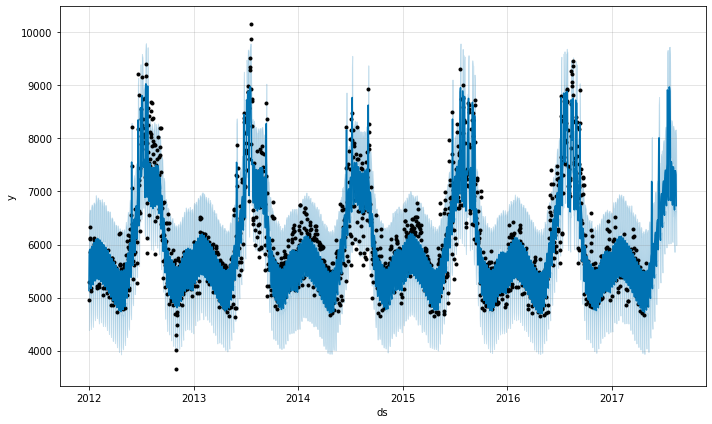

In [ ]:
# below, we can see that our model has predicted better (dark blue) as compared to the univariate model (notebook 07) and our CI also looks better in terms of covering for previous outlier points (black)

fig1 = m.plot(forecast)

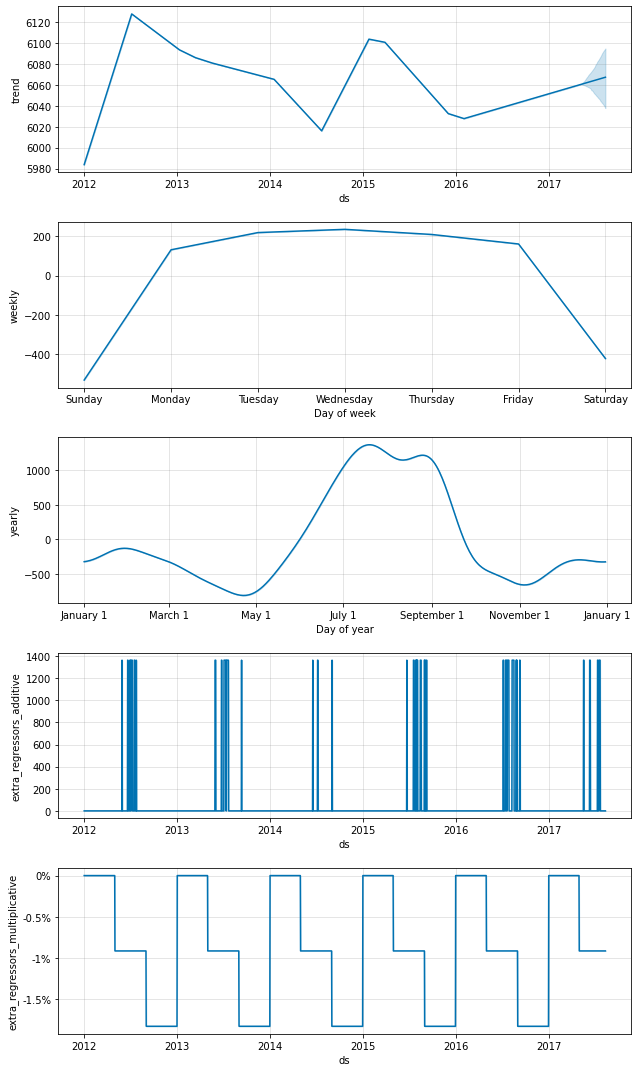

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
# evaluating our model
# we can also write our own evaluation function
# below we are passing initial 731 days of data
# we are telling our cross validation model to use initial 731 days of data and give predictions on 365 days 

from fbprophet.diagnostics import cross_validation, performance_metrics
cv_results = cross_validation( model = m, initial = '731 days', horizon = '365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


In [ ]:
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,204293.922864,451.988853,352.610429,0.062543,0.051056,0.895604
1,37 days 00:00:00,210424.439085,458.720437,359.614485,0.063723,0.051274,0.890110
2,37 days 12:00:00,211653.376540,460.058014,361.875027,0.064102,0.051798,0.890110
3,38 days 00:00:00,215758.752010,464.498388,365.841034,0.064497,0.053251,0.884615
4,38 days 12:00:00,217944.760867,466.845543,369.633793,0.065097,0.054411,0.884615
...,...,...,...,...,...,...,...
653,363 days 00:00:00,156476.433386,395.571022,334.336980,0.061215,0.060978,0.983516
654,363 days 12:00:00,156952.382181,396.172162,334.121377,0.061178,0.060978,0.983516
655,364 days 00:00:00,160084.466586,400.105569,336.855265,0.061888,0.061735,0.978022
656,364 days 12:00:00,159558.111682,399.447258,335.652320,0.061691,0.061467,0.978022


### Previous MAPE = 0.06 to 0.08

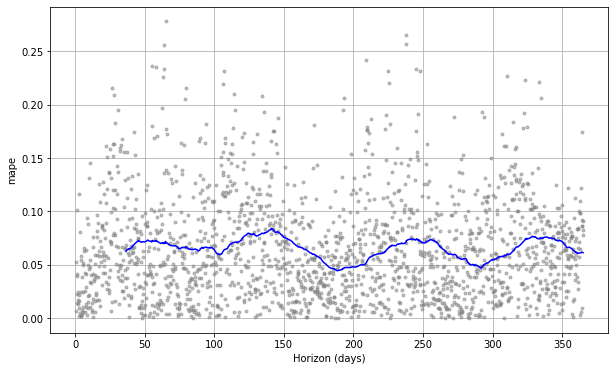

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric="mape")

Why did we feed in the summer_temp and bins values as regressors and not the original temp values as regressors? 
Was that done to tackle seasionality or to give a rough estimate of temp and phase of year?

Main reason is if you have seen the graph most of the year the average temperature is stable and our uni-variate model was not able to model extreme temperature. From EDA in the video you might have noticed the extreme points are temp > 80 and also in specific month. Since prophet treats the regressor as additive linear model it might not be able to model temp variable directly and hence breaking it down.

Can we use SARIMAX or VAR with exogenous variables for the same problem?

Yes you can model it as exogenous variable. It should work on this data as this data is more towards stationary and does not have trend.

Can I just input my time series data with multiple values like forecasting sales using past sales, temperature, S&P500 index, etc.. ?

Yes you can use it provided the other features have correlation to target variables you are forecasting.
